<b>Goal of the project:</b> find the best model to predict next 7 days of my dog's daily consumption.
<br><b>Dataset:</b> I use the dataset made by myself. I note my dog's each meal in the dataset to track his appetite which might be helpful to identify potential sickness and find reasons behind amount of food consumed in a day (e.g. he has been eating a lot for the last 2 days, so lower appetite the following day should not be surprising).
<br><b>Additional details:</b> My dog is a male shiba, born in September 2024, so it is expected his appetite in the first months of the dataset could be strongly affected by the early-puppyhood weight gain process. This issue is examined the Data Preparation section to determine whether the dataset should be sliced.
<br><br><b>Applied methods:</b>
<ul>
    <li>Simple Exponential Smoothing</li>
    <li>Double Exponential Smoothing</li>
    <li>Triple Exponential Smoothing (Holt-Winters)</li>
    <li>ARIMA</li>
    <li>Prophet</li>
</ul>
<b>Important notes:</b>
<ul>
    <li>To keep the project's size acceptable and due to the lack of time it has been decided not to include seasonality as a vital part of this project at the moment. I am aware including a seasonality may improve the project, so I take into account adding this in a future.</li>
    <li>I am aware day-to-day changes can be just a random fluctuation or caused by an external factor (exogenous variable) like temperature. To keep the project's size acceptable and due to the lack of time it has been decided not to include exogenous variables this time.</li>
    <li>Parameter tuning is applied only to selected methods depending on their complexity. Thus, Exponential Smoothing methods will rely on base scenarios (additive trend and autocorrelation-based component).</li>
    <li>Forecast horizon (7 days) is arbitrary.</li>
</ul>

# Libraries and setup

In [1]:
# All-purpose libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
#import os

# Exploratory data analysis
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

# Time series modeling methods and additional functions
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

import arch
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.diagnostic import het_arch

from prophet import Prophet
from prophet.utilities import regressor_coefficients
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric
from prophet.plot import plot_plotly
import plotly.offline as py

# Cross-valiadtion and parameter tuning
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import ParameterGrid

# Model evaluation
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# Setup
warnings.filterwarnings('ignore')
np.set_printoptions(legacy='1.25')

# Useful functions

In [2]:
# Function to assess model and visualize output
def model_assessment(train, test, predictions, chart_title):
    plt.figure(figsize = (10, 4))

    plt.plot(train, label = 'Train')
    plt.plot(test, label = 'Test')
    plt.plot(predictions, label = "Forecast")
    
    plt.title(f"Train, Test and Predictions with {chart_title}")
    plt.legend()
    plt.show()
    
    # Calculating the RMSE, MAE and MAPE
    rmse = root_mean_squared_error(test, predictions)
    mae = mean_absolute_error(test, predictions)
    mape = mean_absolute_percentage_error(test, predictions)
    
    # Print the calculated error metrics
    print(f"The RMSE is {rmse:.2f}")
    print(f"The MAE is {mae:.2f}")
    print(f"The MAPE is {100 * mape:.2f} %")

    return rmse, mae, mape
    

# Data preparation

## Loading dataset

In [3]:
#os.chdir("nauka\pies")
#os.getcwd()

In [4]:
raw_df = pd.read_excel("dog_food_consumption.xlsx", sheet_name="Arkusz2", index_col=0, parse_dates=True, usecols=list(range(4,11)))
raw_df.index.name="date"
raw_df.rename(columns={'porcja [g]': 'consumption [g]'}, inplace=True)
raw_df = raw_df.loc[:, ['consumption [g]']]
raw_df = raw_df.groupby(by='date').sum()
raw_df.index.freq='D'

In [5]:
weight_df = pd.read_excel("dog_food_consumption.xlsx", sheet_name="Arkusz2", index_col=0, parse_dates=True, usecols=[0, 1])
weight_df.dropna(inplace=True)
weight_df.rename(columns={'waga psa [kg]': 'dog weight [kg]'}, inplace=True)
weight_df['diff [kg]'] = weight_df.diff()
weight_df['diff [%]'] = weight_df['dog weight [kg]'].pct_change() * 100

## EDA and dataset slicing

Taking into account I am the author of the dataset, I do not need to use basic Pandas' EDA methods like .info(), .describe(). If it was an external dataset, I would use them.

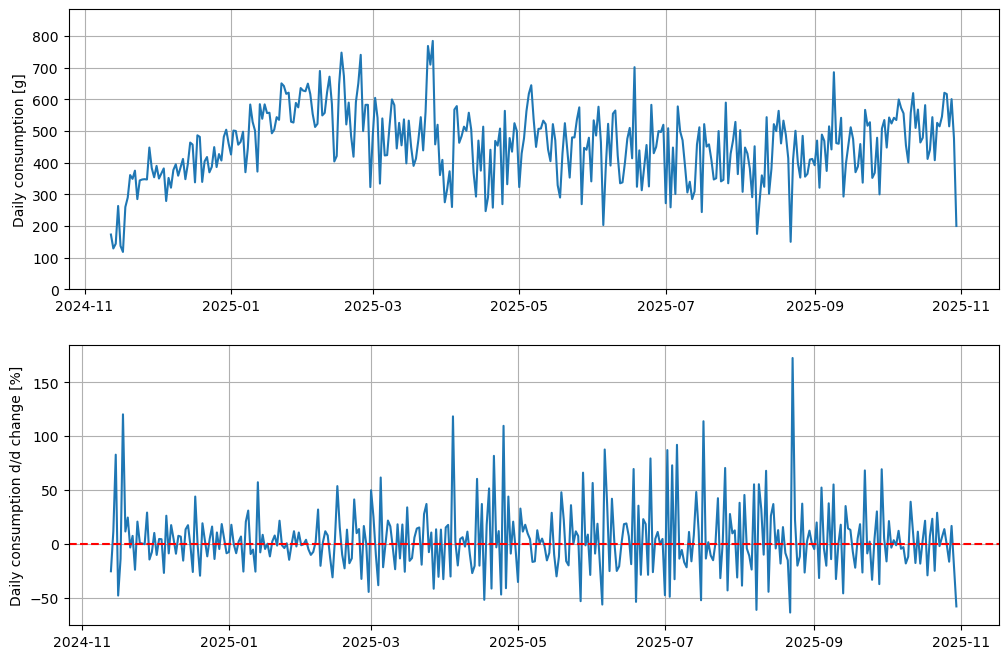

In [6]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(raw_df)
plt.ylabel('Daily consumption [g]')
plt.ylim(bottom=0, top=max(raw_df['consumption [g]'])+100)
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(raw_df.pct_change()*100)
plt.ylabel('Daily consumption d/d change [%]')
plt.axhline(y=0, color='r', ls='--')
#plt.hlines(y=0, color='r', ls='--', xmin=min(raw_df.index), xmax=max(raw_df.index))
plt.grid()

plt.show()

In [7]:
# Dropped the last column to because sometimes that day's data may not be completed yet
df = raw_df.iloc[:-1, :]
df.tail()

consumption [g]
date                       
2025-10-25            621.0
2025-10-26            617.0
2025-10-27            515.0
2025-10-28            601.0
2025-10-29            477.0

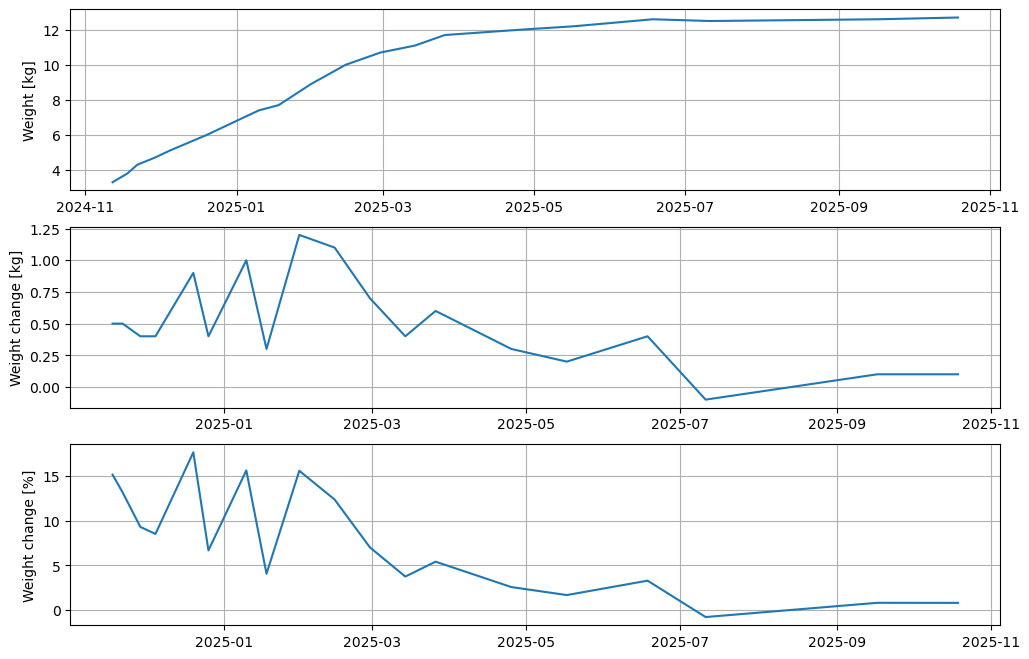

In [8]:
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(weight_df['dog weight [kg]'])
plt.ylabel('Weight [kg]')
#plt.ylim(bottom=0, top=max(weight_df)+100)
plt.grid()

plt.subplot(3, 1, 2)
plt.plot(weight_df['diff [kg]'])
plt.ylabel('Weight change [kg]')
#plt.hlines(y=0, color='r', ls='--', xmin=min(raw_df.index), xmax=max(raw_df.index))
plt.grid()

plt.subplot(3, 1, 3)
plt.plot(weight_df['diff [%]'])
plt.ylabel('Weight change [%]')
plt.grid()

plt.show()

Average male shiba reaches ~10-12 kg, so date of reaching a weight in this area can be treated as the end of the dog's early puppyhood and beginning of the dataset. Around March both appetite and weight gain pace decreased. Thus, the March 1st is treated as the first day of the dataset

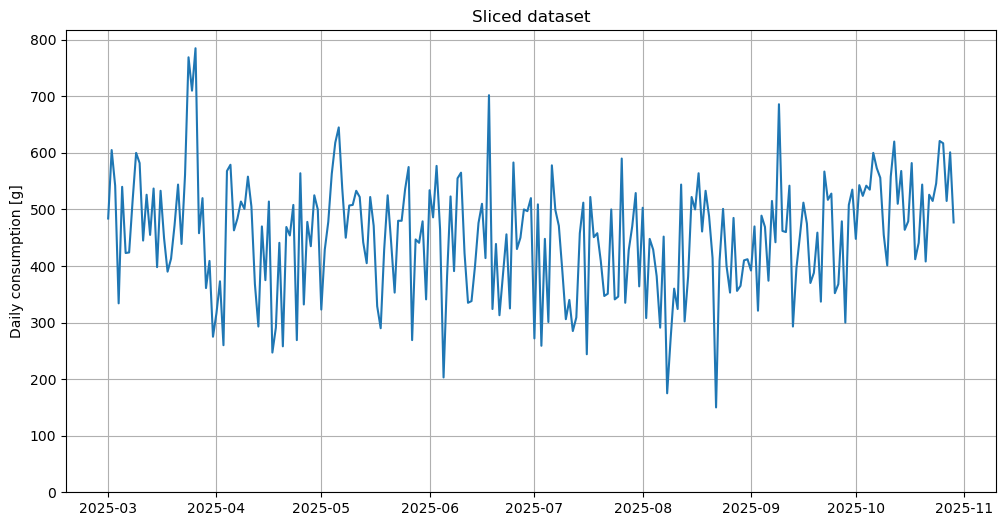

In [9]:
df = df.loc['2025-03-01':]
plt.figure(figsize=(12, 6))
plt.plot(df)
plt.ylabel('Daily consumption [g]')
plt.ylim(bottom=0)
plt.grid()
plt.title('Sliced dataset')
plt.show()

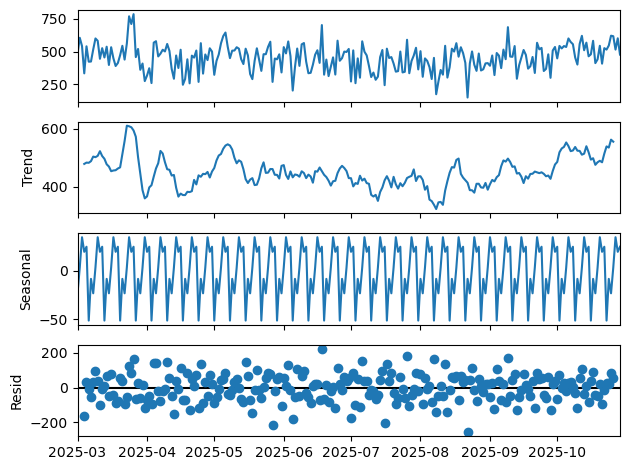

In [10]:
seasonal_decompose(df, model='additive').plot();

Data does not show any multiplicative behavior. Taking this into account, data trends are assumed to be additive.

## Train-test split

In [11]:
periods = 7
train = df.iloc[:-periods]
test = df.iloc[-periods:]

## Autocorrelations

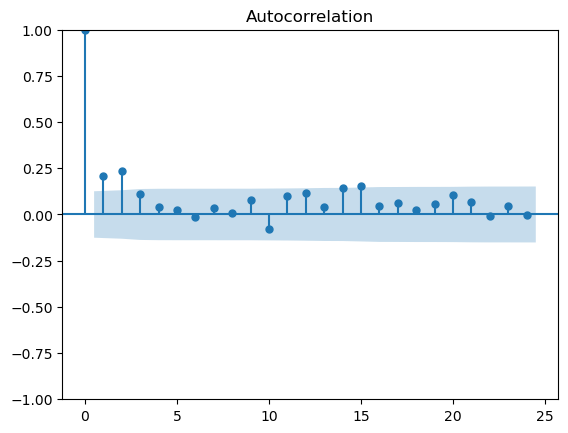

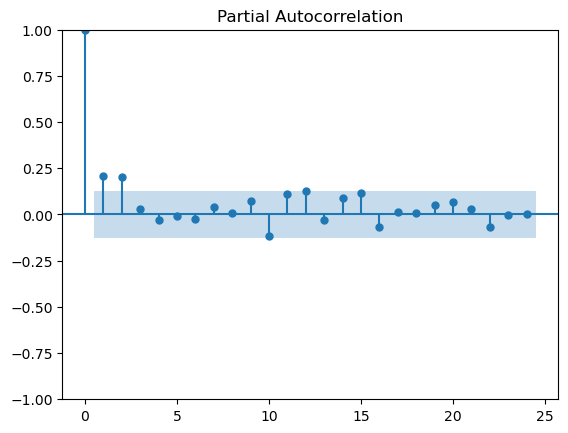

In [12]:
plot_acf(df)
plot_pacf(df);

Basing on the default intervals, ACF (q) and PACF (p) values for lags 1 and 2 are barely significant. Daily consumption does not seem to be strongly related to past values (in other words, applied methods may not provide satisfying results).

# Simple Exponential Smoothing

In [13]:
ses_model = SimpleExpSmoothing(train).fit()
ses_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       SimpleExpSmoothing Model Results                       
==============================================================================
Dep. Variable:        consumption [g]   No. Observations:                  236
Model:             SimpleExpSmoothing   SSE                        2416443.285
Optimized:                       True   AIC                           2183.218
Trend:                           None   BIC                           2190.146
Seasonal:                        None   AICC                          2183.391
Seasonal Periods:                None   Date:                 Thu, 30 Oct 2025
Box-Cox:                        False   Time:                         20:03:50
Box-Cox Coeff.:                  None                                         
==============================================================================
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.0609213                alpha                 True
initial_level              484.00000                  l.0                False
------------------------------------------------------------------------------
"""

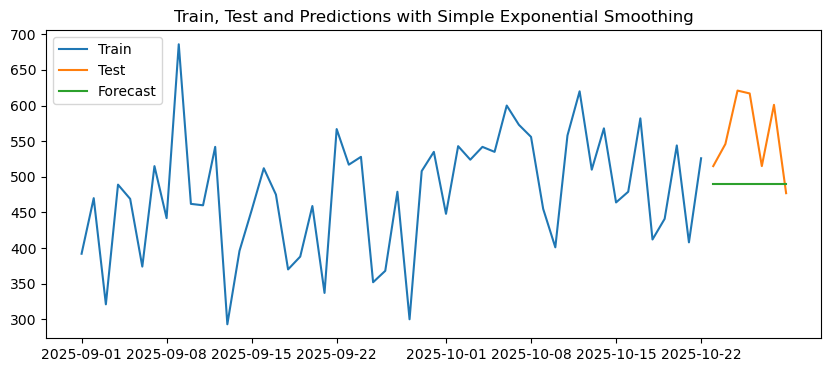

The RMSE is 84.51
The MAE is 69.58
The MAPE is 11.81 %


In [14]:
ses_pred = ses_model.forecast(periods)
ses_rmse, ses_mae, ses_mape = model_assessment(train.loc['2025-09':], test, ses_pred, 'Simple Exponential Smoothing')

# Double Exponential Smoothing

In [15]:
model_double = ExponentialSmoothing(train, trend='additive', seasonal=None).fit()
model_double.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       ExponentialSmoothing Model Results                       
================================================================================
Dep. Variable:          consumption [g]   No. Observations:                  236
Model:             ExponentialSmoothing   SSE                        2417683.692
Optimized:                         True   AIC                           2187.339
Trend:                         Additive   BIC                           2201.195
Seasonal:                          None   AICC                          2187.706
Seasonal Periods:                  None   Date:                 Thu, 30 Oct 2025
Box-Cox:                          False   Time:                         20:03:51
Box-Cox Coeff.:                    None                                         
==============================================================================
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.0605396                alpha                 True
smoothing_trend             0.000000                 beta                 True
initial_level              476.07452                  l.0                 True
initial_trend              0.0346582                  b.0                 True
------------------------------------------------------------------------------
"""

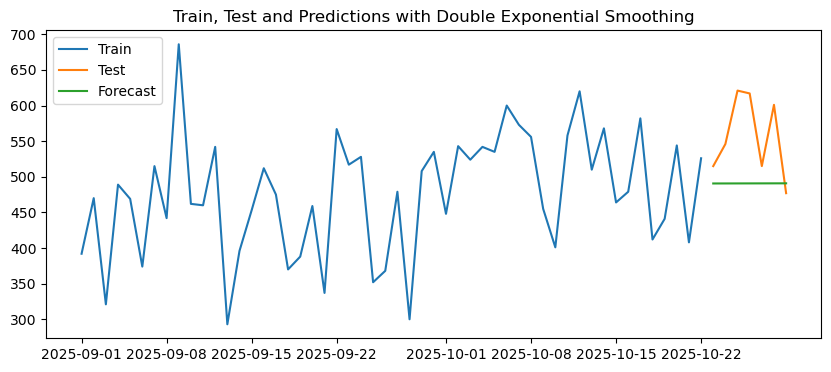

The RMSE is 84.09
The MAE is 69.22
The MAPE is 11.75 %


In [16]:
double_pred = model_double.forecast(periods)
double_rmse, double_mae, double_mape = model_assessment(train.loc['2025-09':], test, double_pred, 'Double Exponential Smoothing')

# Triple Exponential Smoothing (Holt-Winters)

Seasonal periods has been assumed using autocorrelation plots.

In [17]:
model_holt = ExponentialSmoothing(train, trend='additive', seasonal='additive', seasonal_periods=2).fit()
model_holt.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       ExponentialSmoothing Model Results                       
================================================================================
Dep. Variable:          consumption [g]   No. Observations:                  236
Model:             ExponentialSmoothing   SSE                        2391906.489
Optimized:                         True   AIC                           2188.810
Trend:                         Additive   BIC                           2209.593
Seasonal:                      Additive   AICC                          2189.444
Seasonal Periods:                     2   Date:                 Thu, 30 Oct 2025
Box-Cox:                          False   Time:                         20:03:51
Box-Cox Coeff.:                    None                                         
=================================================================================
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.0618872                alpha                 True
smoothing_trend                0.000000                 beta                 True
smoothing_seasonal             0.000000                gamma                 True
initial_level                 483.36489                  l.0                 True
initial_trend                 0.0107466                  b.0                 True
initial_seasons.0            -7.7098506                  s.0                 True
initial_seasons.1             12.091438                  s.1                 True
---------------------------------------------------------------------------------
"""

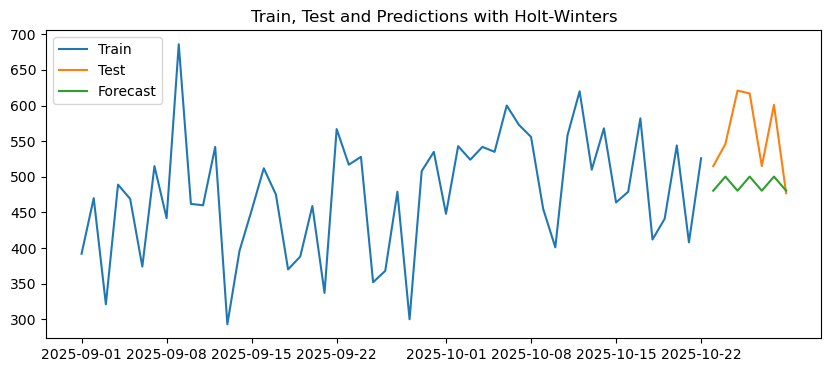

The RMSE is 82.81
The MAE is 68.03
The MAPE is 11.55 %


In [18]:
holt_pred = model_holt.forecast(periods)
holt_rmse, holt_mae, holt_mape = model_assessment(train.loc['2025-09':], test, holt_pred, 'Holt-Winters')

# Exponential Smoothing summary

In [19]:
pd.DataFrame(data=[ses_model.params, model_double.params, model_holt.params], index=['Simple ES', 'Double ES', 'Triple ES'])

smoothing_level  smoothing_trend  smoothing_seasonal  \
Simple ES         0.060921              NaN                 NaN   
Double ES         0.060540              0.0                 NaN   
Triple ES         0.061887              0.0                 0.0   

           damping_trend  initial_level  initial_trend  \
Simple ES            NaN     484.000000            NaN   
Double ES            NaN     476.074523       0.034658   
Triple ES            NaN     483.364894       0.010747   

                                  initial_seasons  use_boxcox lamda  \
Simple ES                                      []       False  None   
Double ES                                      []       False  None   
Triple ES  [-7.7098505734692, 12.091437855286046]       False  None   

           remove_bias  
Simple ES        False  
Double ES        False  
Triple ES        False

In [20]:
es_metrics = pd.DataFrame(
    data={
        'RMSE': [ses_rmse, double_rmse, holt_rmse], 
        'MAE': [ses_mae, double_mae, holt_mae], 
        'MAPE': [ses_mape, double_mape, holt_mape]
         }, 
    index=['Simple ES', 'Double ES', 'Triple ES']
)
es_metrics

RMSE        MAE      MAPE
Simple ES  84.513007  69.583568  0.118118
Double ES  84.092237  69.220737  0.117509
Triple ES  82.805169  68.033841  0.115459

# ARIMA

## Testing stationarity

To make a reliable ARIMA model it is needed to check stationarity which is done by the Augmented Dickey-Fuller test.

In [21]:
adf_res = adfuller(df)
print(f'ADF statistic: {adf_res[0]}')
print(f'p-value: {adf_res[1]}')
if adf_res[1] < 0.05:
    print('The series is stationary.')
    print('The series is ready to be inputed into a model.')
else:
    print('The series is NOT stationary.')
    print('The series needs to modified e.g. set different range of differentate the series') 

ADF statistic: -7.918837546209661
p-value: 3.7718775646131505e-12
The series is stationary.
The series is ready to be inputed into a model.


## Estimating parameters

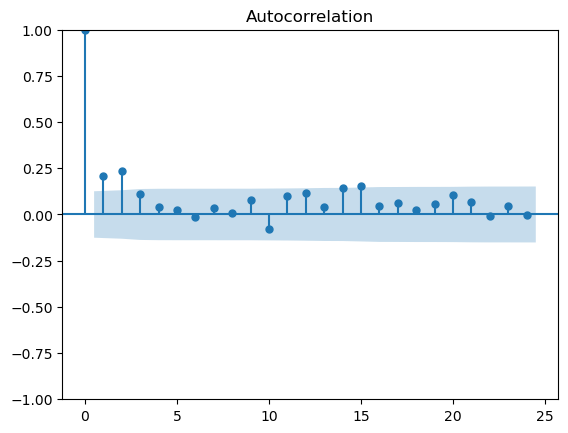

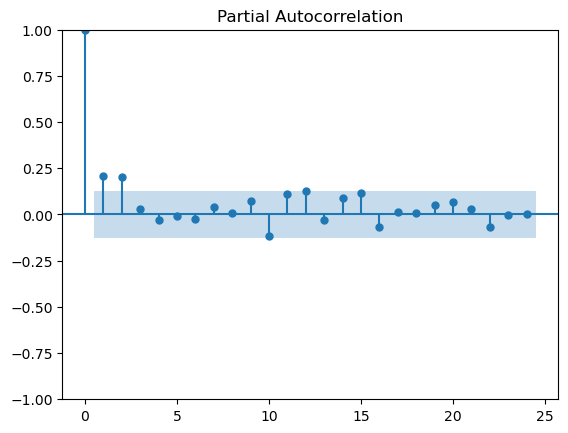

In [22]:
plot_acf(df)
plot_pacf(df);

In [23]:
pq = []
aic = []
bic = []
for p in range(0, 8):
    for q in range(0, 8):
        model = SARIMAX(df, order=(p, 0, q), seasonal_order=(0, 0, 0, 0))
        res = model.fit()
        pq.append( (p, 0, q) )
        aic.append(res.aic)
        bic.append(res.bic)
    print(f'Models for the p={p} have been done.')
results = pd.DataFrame(data={'p q': pq, 'aic': aic, 'bic': bic})
results.set_index('p q', inplace=True)
print(f'The lowest AIC value is for the {results['aic'].idxmin()}', 
      f'The lowest BIC value is for the {results['bic'].idxmin()}', 
      sep='\n')

Models for the p=0 have been done.
Models for the p=1 have been done.
Models for the p=2 have been done.
Models for the p=3 have been done.
Models for the p=4 have been done.
Models for the p=5 have been done.
Models for the p=6 have been done.
Models for the p=7 have been done.
The lowest AIC value is for the (1, 0, 3)
The lowest BIC value is for the (1, 0, 1)


<Axes: xlabel='p q'>

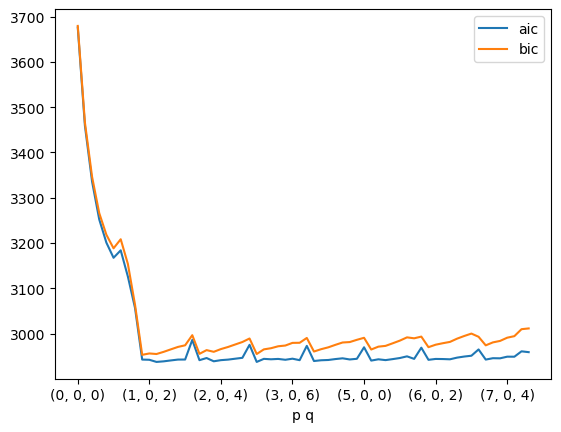

In [24]:
results.plot()

In [25]:
results.sort_values(by='aic', ascending=True).head(8)

aic          bic
p q                                
(1, 0, 3)  2937.391002  2954.856309
(3, 0, 1)  2937.393449  2954.858756
(1, 0, 4)  2938.669206  2959.627575
(2, 0, 3)  2938.781334  2959.739703
(4, 0, 1)  2939.392527  2960.350896
(5, 0, 1)  2940.326229  2964.777659
(1, 0, 5)  2940.682216  2965.133646
(4, 0, 2)  2941.053211  2965.504641

According to above values, the best results (lowest AIC and BIC) are for p and q values equal to 5 or less. Thus, this range of values (range(1, 6)) will be tested.

In [26]:
# Define the parameter options
param_grid = {
    'p': [1, 2, 3, 4, 5], 
    'd': [0], 
    'q': [1, 2, 3, 4, 5]
}
grid = ParameterGrid(param_grid)

# Do the time series splits
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits, test_size=periods)

In [27]:
# Perform parameter tuning
rmse_list = []
mae_list = []
mape_list = []

# Iterate over the parameters
for params in grid:
    fold_rmse = []
    fold_mae = []
    fold_mape = []

    # Build the model
    for train_index, test_index in tscv.split(df):
        train = df.iloc[train_index]
        test = df.iloc[test_index]
        
        # ARIMA
        model_arima = SARIMAX(
            train['consumption [g]'], 
            order=(params['p'], params['d'], params['q']), 
            seasonal_order=(0, 0, 0, 0)
        ).fit()

        # Make predictions, calculate the error and store results
        predictions_arima = model_arima.forecast(steps=periods)

        # Assess the predictions
        rmse = root_mean_squared_error(test['consumption [g]'], predictions_arima)
        mae = mean_absolute_error(test['consumption [g]'], predictions_arima)
        mape = mean_absolute_percentage_error(test['consumption [g]'], predictions_arima)
        fold_rmse.append(rmse)
        fold_mae.append(mae)
        fold_mape.append(mape)
    
    # Store the results
    rmse_list.append(np.mean(fold_rmse))
    mae_list.append(np.mean(fold_mae))
    mape_list.append(np.mean(fold_mape))

    print(f'Params {params} are completed')
    

Params {'d': 0, 'p': 1, 'q': 1} are completed
Params {'d': 0, 'p': 1, 'q': 2} are completed
Params {'d': 0, 'p': 1, 'q': 3} are completed
Params {'d': 0, 'p': 1, 'q': 4} are completed
Params {'d': 0, 'p': 1, 'q': 5} are completed
Params {'d': 0, 'p': 2, 'q': 1} are completed
Params {'d': 0, 'p': 2, 'q': 2} are completed
Params {'d': 0, 'p': 2, 'q': 3} are completed
Params {'d': 0, 'p': 2, 'q': 4} are completed
Params {'d': 0, 'p': 2, 'q': 5} are completed
Params {'d': 0, 'p': 3, 'q': 1} are completed
Params {'d': 0, 'p': 3, 'q': 2} are completed
Params {'d': 0, 'p': 3, 'q': 3} are completed
Params {'d': 0, 'p': 3, 'q': 4} are completed
Params {'d': 0, 'p': 3, 'q': 5} are completed
Params {'d': 0, 'p': 4, 'q': 1} are completed
Params {'d': 0, 'p': 4, 'q': 2} are completed
Params {'d': 0, 'p': 4, 'q': 3} are completed
Params {'d': 0, 'p': 4, 'q': 4} are completed
Params {'d': 0, 'p': 4, 'q': 5} are completed
Params {'d': 0, 'p': 5, 'q': 1} are completed
Params {'d': 0, 'p': 5, 'q': 2} ar

In [28]:
metrics_df = pd.DataFrame(list(grid))
metrics_df['rmse'] = rmse_list
metrics_df['mae'] = mae_list
metrics_df['mape'] = mape_list
metrics_df

d  p  q        rmse         mae      mape
0   0  1  1   84.827094   76.011099  0.152481
1   0  1  2   86.709230   77.450085  0.154112
2   0  1  3   90.388912   80.725864  0.159788
3   0  1  4   91.386630   81.435668  0.161131
4   0  1  5  146.257463  127.323868  0.256695
5   0  2  1   87.781051   78.217424  0.155178
6   0  2  2   85.539065   76.770035  0.154041
7   0  2  3   90.613289   80.836108  0.160276
8   0  2  4   90.764270   80.613453  0.159204
9   0  2  5   91.717667   82.157600  0.162692
10  0  3  1   91.693902   81.833101  0.161999
11  0  3  2   87.700800   78.359170  0.155818
12  0  3  3   82.363785   74.717750  0.149923
13  0  3  4   93.524653   82.125881  0.162500
14  0  3  5   93.572286   81.970898  0.163378
15  0  4  1   93.113763   82.552109  0.162331
16  0  4  2   91.674882   82.826883  0.164766
17  0  4  3   92.184087   81.628301  0.159856
18  0  4  4   87.277761   78.375402  0.156571
19  0  4  5   86.347146   77.867802  0.153986
20  0  5  1   93.370864   82.446702  0.161787
21  0  5  2  160.119169  151.310691  0.321770
22  0  5  3   96.530917   86.430327  0.171272
23  0  5  4   88.387455   80.138603  0.159226
24  0  5  5   94.142278   80.206298  0.161071

In [29]:
if metrics_df.loc[metrics_df['rmse'].idxmin()].equals(metrics_df.loc[metrics_df['mae'].idxmin()]) and metrics_df.loc[metrics_df['rmse'].idxmin()].equals(metrics_df.loc[metrics_df['mape'].idxmin()]):
    print('RMSE, MAE and MAPE metrics have the lowest values for the same model')
else:
    print('RMSE, MAE and MAPE metrics have the lowest values for different models')

RMSE, MAE and MAPE metrics have the lowest values for the same model


In [30]:
arima_params = grid[metrics_df['rmse'].idxmin()]

## Running the final model 

In [31]:
model_arima = SARIMAX(
        train['consumption [g]'], 
        order=(arima_params['p'], arima_params['d'], arima_params['q']), 
        seasonal_order=(0, 0, 0, 0)
    ).fit()
arima_pred = model_arima.forecast(steps=periods)

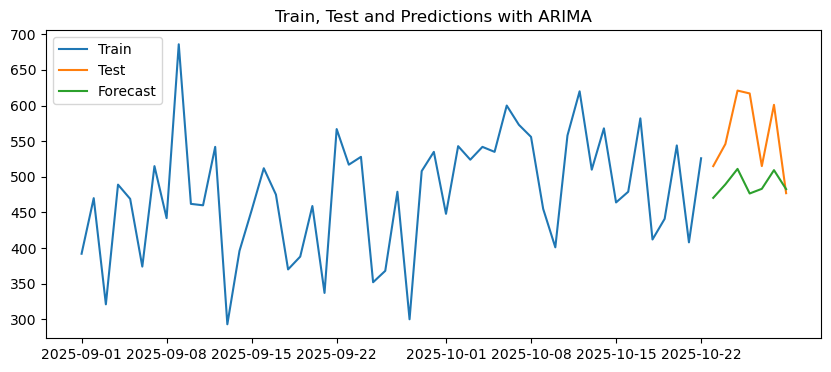

The RMSE is 81.45
The MAE is 68.67
The MAPE is 11.73 %


In [32]:
arima_rmse, arima_mae, arima_mape = model_assessment(train.loc['2025-09':], test, arima_pred, 'ARIMA')

In [33]:
arima_mape

0.1172924042997466

In [34]:
arima_metrics = pd.DataFrame(data={'RMSE': arima_rmse, 'MAE': arima_mae, 'MAPE': arima_mape}, index=['ARIMA'])
arima_metrics

RMSE        MAE      MAPE
ARIMA  81.450479  68.670596  0.117292

# Prophet

## Adjusting dataframe to Prophet

In [35]:
prophet_df = df.reset_index()
prophet_df.rename(columns={'date': 'ds', 'consumption [g]': 'y'}, inplace=True)
prophet_train = prophet_df.iloc[:-periods]
prophet_test = prophet_df.iloc[-periods:]

In [36]:
prophet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243 entries, 0 to 242
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      243 non-null    datetime64[ns]
 1   y       243 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.9 KB


## Estimating parameters

In [37]:
prophet_param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.05, 0.1, 0.5], # The higher, the trend is more vulnerable to noise
    'n_changepoints': [10, 20, 40], # Max number of potential trend change locations
    'changepoint_range': [0.8, 0.9, 1.0] # Fraction of the history where changepoints are allowed
}
grid = ParameterGrid(prophet_param_grid)

In [38]:
# Perform parameter tuning
rmse_list = []
mae_list = []
mape_list = []

# Iterate over the parameters
for params in grid:
    fold_rmse = []
    fold_mae = []
    fold_mape = []

    prophet_model = Prophet(
        yearly_seasonality=False, 
        weekly_seasonality=False, 
        daily_seasonality=False,
        **params
    ).fit(prophet_train)

    # Cross-Validations
    df_cv = cross_validation(model=prophet_model, period='7 days', initial='180 days', horizon='7 days', parallel='processes')

    # Calculate performance metrics
    df_p = performance_metrics(df_cv, rolling_window=1)
    
    # Store the results
    rmse_list.append(df_p['rmse'].values[0])
    mae_list.append(df_p['mae'].values[0])
    mape_list.append(df_p['mape'].values[0])

    print(f'Params {params} are completed')

20:05:47 - cmdstanpy - INFO - Chain [1] start processing
20:05:47 - cmdstanpy - INFO - Chain [1] done processing
20:05:51 - cmdstanpy - INFO - Chain [1] start processing
20:05:51 - cmdstanpy - INFO - Chain [1] done processing


Params {'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'n_changepoints': 10} are completed


20:05:51 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:05:51 - cmdstanpy - INFO - Chain [1] start processing
20:05:52 - cmdstanpy - INFO - Chain [1] done processing
20:05:56 - cmdstanpy - INFO - Chain [1] start processing


Params {'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'n_changepoints': 20} are completed


20:05:56 - cmdstanpy - INFO - Chain [1] done processing
20:05:56 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:05:56 - cmdstanpy - INFO - Chain [1] start processing
20:05:56 - cmdstanpy - INFO - Chain [1] done processing
20:06:05 - cmdstanpy - INFO - Chain [1] start processing


Params {'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'n_changepoints': 40} are completed


20:06:05 - cmdstanpy - INFO - Chain [1] done processing
20:06:09 - cmdstanpy - INFO - Chain [1] start processing
20:06:09 - cmdstanpy - INFO - Chain [1] done processing
20:06:09 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted


Params {'changepoint_prior_scale': 0.001, 'changepoint_range': 0.9, 'n_changepoints': 10} are completed


Optimization terminated abnormally. Falling back to Newton.
20:06:09 - cmdstanpy - INFO - Chain [1] start processing
20:06:09 - cmdstanpy - INFO - Chain [1] done processing
20:06:14 - cmdstanpy - INFO - Chain [1] start processing
20:06:14 - cmdstanpy - INFO - Chain [1] done processing


Params {'changepoint_prior_scale': 0.001, 'changepoint_range': 0.9, 'n_changepoints': 20} are completed


20:06:14 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:06:14 - cmdstanpy - INFO - Chain [1] start processing
20:06:15 - cmdstanpy - INFO - Chain [1] done processing
20:06:21 - cmdstanpy - INFO - Chain [1] start processing


Params {'changepoint_prior_scale': 0.001, 'changepoint_range': 0.9, 'n_changepoints': 40} are completed


20:06:21 - cmdstanpy - INFO - Chain [1] done processing
20:06:24 - cmdstanpy - INFO - Chain [1] start processing


Params {'changepoint_prior_scale': 0.001, 'changepoint_range': 1.0, 'n_changepoints': 10} are completed


20:06:25 - cmdstanpy - INFO - Chain [1] done processing
20:06:25 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:06:25 - cmdstanpy - INFO - Chain [1] start processing
20:06:25 - cmdstanpy - INFO - Chain [1] done processing
20:06:30 - cmdstanpy - INFO - Chain [1] start processing


Params {'changepoint_prior_scale': 0.001, 'changepoint_range': 1.0, 'n_changepoints': 20} are completed


20:06:30 - cmdstanpy - INFO - Chain [1] done processing
20:06:30 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:06:30 - cmdstanpy - INFO - Chain [1] start processing
20:06:30 - cmdstanpy - INFO - Chain [1] done processing
20:06:38 - cmdstanpy - INFO - Chain [1] start processing


Params {'changepoint_prior_scale': 0.001, 'changepoint_range': 1.0, 'n_changepoints': 40} are completed


20:06:38 - cmdstanpy - INFO - Chain [1] done processing
20:06:41 - cmdstanpy - INFO - Chain [1] start processing


Params {'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'n_changepoints': 10} are completed


20:06:41 - cmdstanpy - INFO - Chain [1] done processing
20:06:45 - cmdstanpy - INFO - Chain [1] start processing
20:06:45 - cmdstanpy - INFO - Chain [1] done processing


Params {'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'n_changepoints': 20} are completed


20:06:49 - cmdstanpy - INFO - Chain [1] start processing
20:06:49 - cmdstanpy - INFO - Chain [1] done processing


Params {'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'n_changepoints': 40} are completed


20:06:53 - cmdstanpy - INFO - Chain [1] start processing
20:06:53 - cmdstanpy - INFO - Chain [1] done processing


Params {'changepoint_prior_scale': 0.01, 'changepoint_range': 0.9, 'n_changepoints': 10} are completed


20:06:57 - cmdstanpy - INFO - Chain [1] start processing


Params {'changepoint_prior_scale': 0.01, 'changepoint_range': 0.9, 'n_changepoints': 20} are completed


20:06:57 - cmdstanpy - INFO - Chain [1] done processing
20:07:00 - cmdstanpy - INFO - Chain [1] start processing
20:07:01 - cmdstanpy - INFO - Chain [1] done processing


Params {'changepoint_prior_scale': 0.01, 'changepoint_range': 0.9, 'n_changepoints': 40} are completed


20:07:04 - cmdstanpy - INFO - Chain [1] start processing


Params {'changepoint_prior_scale': 0.01, 'changepoint_range': 1.0, 'n_changepoints': 10} are completed


20:07:04 - cmdstanpy - INFO - Chain [1] done processing
20:07:08 - cmdstanpy - INFO - Chain [1] start processing


Params {'changepoint_prior_scale': 0.01, 'changepoint_range': 1.0, 'n_changepoints': 20} are completed


20:07:08 - cmdstanpy - INFO - Chain [1] done processing
20:07:12 - cmdstanpy - INFO - Chain [1] start processing


Params {'changepoint_prior_scale': 0.01, 'changepoint_range': 1.0, 'n_changepoints': 40} are completed


20:07:12 - cmdstanpy - INFO - Chain [1] done processing
20:07:16 - cmdstanpy - INFO - Chain [1] start processing
20:07:16 - cmdstanpy - INFO - Chain [1] done processing


Params {'changepoint_prior_scale': 0.05, 'changepoint_range': 0.8, 'n_changepoints': 10} are completed


20:07:19 - cmdstanpy - INFO - Chain [1] start processing
20:07:19 - cmdstanpy - INFO - Chain [1] done processing


Params {'changepoint_prior_scale': 0.05, 'changepoint_range': 0.8, 'n_changepoints': 20} are completed


20:07:23 - cmdstanpy - INFO - Chain [1] start processing


Params {'changepoint_prior_scale': 0.05, 'changepoint_range': 0.8, 'n_changepoints': 40} are completed


20:07:23 - cmdstanpy - INFO - Chain [1] done processing
20:07:27 - cmdstanpy - INFO - Chain [1] start processing


Params {'changepoint_prior_scale': 0.05, 'changepoint_range': 0.9, 'n_changepoints': 10} are completed


20:07:27 - cmdstanpy - INFO - Chain [1] done processing
20:07:31 - cmdstanpy - INFO - Chain [1] start processing


Params {'changepoint_prior_scale': 0.05, 'changepoint_range': 0.9, 'n_changepoints': 20} are completed


20:07:31 - cmdstanpy - INFO - Chain [1] done processing
20:07:34 - cmdstanpy - INFO - Chain [1] start processing


Params {'changepoint_prior_scale': 0.05, 'changepoint_range': 0.9, 'n_changepoints': 40} are completed


20:07:34 - cmdstanpy - INFO - Chain [1] done processing
20:07:38 - cmdstanpy - INFO - Chain [1] start processing
20:07:38 - cmdstanpy - INFO - Chain [1] done processing


Params {'changepoint_prior_scale': 0.05, 'changepoint_range': 1.0, 'n_changepoints': 10} are completed


20:07:42 - cmdstanpy - INFO - Chain [1] start processing


Params {'changepoint_prior_scale': 0.05, 'changepoint_range': 1.0, 'n_changepoints': 20} are completed


20:07:42 - cmdstanpy - INFO - Chain [1] done processing
20:07:46 - cmdstanpy - INFO - Chain [1] start processing


Params {'changepoint_prior_scale': 0.05, 'changepoint_range': 1.0, 'n_changepoints': 40} are completed


20:07:46 - cmdstanpy - INFO - Chain [1] done processing
20:07:50 - cmdstanpy - INFO - Chain [1] start processing


Params {'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'n_changepoints': 10} are completed


20:07:50 - cmdstanpy - INFO - Chain [1] done processing
20:07:53 - cmdstanpy - INFO - Chain [1] start processing


Params {'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'n_changepoints': 20} are completed


20:07:54 - cmdstanpy - INFO - Chain [1] done processing
20:07:57 - cmdstanpy - INFO - Chain [1] start processing
20:07:57 - cmdstanpy - INFO - Chain [1] done processing


Params {'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'n_changepoints': 40} are completed


20:08:01 - cmdstanpy - INFO - Chain [1] start processing


Params {'changepoint_prior_scale': 0.1, 'changepoint_range': 0.9, 'n_changepoints': 10} are completed


20:08:01 - cmdstanpy - INFO - Chain [1] done processing
20:08:05 - cmdstanpy - INFO - Chain [1] start processing


Params {'changepoint_prior_scale': 0.1, 'changepoint_range': 0.9, 'n_changepoints': 20} are completed


20:08:05 - cmdstanpy - INFO - Chain [1] done processing
20:08:09 - cmdstanpy - INFO - Chain [1] start processing
20:08:09 - cmdstanpy - INFO - Chain [1] done processing


Params {'changepoint_prior_scale': 0.1, 'changepoint_range': 0.9, 'n_changepoints': 40} are completed


20:08:12 - cmdstanpy - INFO - Chain [1] start processing
20:08:12 - cmdstanpy - INFO - Chain [1] done processing


Params {'changepoint_prior_scale': 0.1, 'changepoint_range': 1.0, 'n_changepoints': 10} are completed


20:08:16 - cmdstanpy - INFO - Chain [1] start processing


Params {'changepoint_prior_scale': 0.1, 'changepoint_range': 1.0, 'n_changepoints': 20} are completed


20:08:16 - cmdstanpy - INFO - Chain [1] done processing
20:08:20 - cmdstanpy - INFO - Chain [1] start processing


Params {'changepoint_prior_scale': 0.1, 'changepoint_range': 1.0, 'n_changepoints': 40} are completed


20:08:20 - cmdstanpy - INFO - Chain [1] done processing
20:08:24 - cmdstanpy - INFO - Chain [1] start processing


Params {'changepoint_prior_scale': 0.5, 'changepoint_range': 0.8, 'n_changepoints': 10} are completed


20:08:24 - cmdstanpy - INFO - Chain [1] done processing
20:08:28 - cmdstanpy - INFO - Chain [1] start processing


Params {'changepoint_prior_scale': 0.5, 'changepoint_range': 0.8, 'n_changepoints': 20} are completed


20:08:28 - cmdstanpy - INFO - Chain [1] done processing
20:08:31 - cmdstanpy - INFO - Chain [1] start processing


Params {'changepoint_prior_scale': 0.5, 'changepoint_range': 0.8, 'n_changepoints': 40} are completed


20:08:31 - cmdstanpy - INFO - Chain [1] done processing
20:08:35 - cmdstanpy - INFO - Chain [1] start processing


Params {'changepoint_prior_scale': 0.5, 'changepoint_range': 0.9, 'n_changepoints': 10} are completed


20:08:35 - cmdstanpy - INFO - Chain [1] done processing
20:08:39 - cmdstanpy - INFO - Chain [1] start processing


Params {'changepoint_prior_scale': 0.5, 'changepoint_range': 0.9, 'n_changepoints': 20} are completed


20:08:39 - cmdstanpy - INFO - Chain [1] done processing
20:08:43 - cmdstanpy - INFO - Chain [1] start processing


Params {'changepoint_prior_scale': 0.5, 'changepoint_range': 0.9, 'n_changepoints': 40} are completed


20:08:43 - cmdstanpy - INFO - Chain [1] done processing
20:08:46 - cmdstanpy - INFO - Chain [1] start processing


Params {'changepoint_prior_scale': 0.5, 'changepoint_range': 1.0, 'n_changepoints': 10} are completed


20:08:47 - cmdstanpy - INFO - Chain [1] done processing
20:08:50 - cmdstanpy - INFO - Chain [1] start processing


Params {'changepoint_prior_scale': 0.5, 'changepoint_range': 1.0, 'n_changepoints': 20} are completed


20:08:50 - cmdstanpy - INFO - Chain [1] done processing


Params {'changepoint_prior_scale': 0.5, 'changepoint_range': 1.0, 'n_changepoints': 40} are completed


In [39]:
all_prophet_metrics = pd.DataFrame(grid)
all_prophet_metrics['rmse'] = rmse_list
all_prophet_metrics['mae'] = mae_list
all_prophet_metrics['mape'] = mape_list
all_prophet_metrics.sort_values(by='rmse', ascending=True).head(5)

changepoint_prior_scale  changepoint_range  n_changepoints       rmse  \
40                      0.5                0.9              20  90.945756   
41                      0.5                0.9              40  91.010691   
39                      0.5                0.9              10  91.047461   
38                      0.5                0.8              40  91.059572   
44                      0.5                1.0              40  91.171545   

          mae      mape  
40  76.020098  0.163849  
41  75.600303  0.163439  
39  76.251976  0.164137  
38  76.316601  0.164283  
44  76.000777  0.164087

In [40]:
all_prophet_metrics.sort_values(by='mae', ascending=True).head(5)

changepoint_prior_scale  changepoint_range  n_changepoints       rmse  \
41                      0.5                0.9              40  91.010691   
44                      0.5                1.0              40  91.171545   
40                      0.5                0.9              20  90.945756   
39                      0.5                0.9              10  91.047461   
38                      0.5                0.8              40  91.059572   

          mae      mape  
41  75.600303  0.163439  
44  76.000777  0.164087  
40  76.020098  0.163849  
39  76.251976  0.164137  
38  76.316601  0.164283

In [41]:
all_prophet_metrics.sort_values(by='mape', ascending=True).head(5)

changepoint_prior_scale  changepoint_range  n_changepoints       rmse  \
41                      0.5                0.9              40  91.010691   
40                      0.5                0.9              20  90.945756   
44                      0.5                1.0              40  91.171545   
39                      0.5                0.9              10  91.047461   
43                      0.5                1.0              20  91.189392   

          mae      mape  
41  75.600303  0.163439  
40  76.020098  0.163849  
44  76.000777  0.164087  
39  76.251976  0.164137  
43  76.336959  0.164207

It can be seen definetily the best results are for parameters combination no. 41 and 40. It has been decided to use combination no. 41.

In [42]:
prophet_params = grid[41]

## Running the final model

In [43]:
prophet_model.make_future_dataframe(periods=7)

ds
0   2025-03-01
1   2025-03-02
2   2025-03-03
3   2025-03-04
4   2025-03-05
..         ...
238 2025-10-25
239 2025-10-26
240 2025-10-27
241 2025-10-28
242 2025-10-29

[243 rows x 1 columns]

In [44]:
prophet_model = Prophet(
        yearly_seasonality=False, 
        weekly_seasonality=False, 
        daily_seasonality=False,
        **prophet_params
    )
#prophet_model.add_seasonality(name='2day', period=2, fourier_order=2)
prophet_model.fit(prophet_train)
prophet_future = prophet_model.make_future_dataframe(periods=7)
prophet_forecast = prophet_model.predict(prophet_future)
prophet_forecast.tail(7)

20:08:54 - cmdstanpy - INFO - Chain [1] start processing
20:08:54 - cmdstanpy - INFO - Chain [1] done processing


ds       trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
236 2025-10-23  514.692191  389.691464  637.699258   514.692191   514.692191   
237 2025-10-24  516.282939  393.229534  630.033949   516.259524   516.303934   
238 2025-10-25  517.873687  386.733463  638.178281   517.815826   517.926198   
239 2025-10-26  519.464435  386.624854  648.923027   519.362824   519.560279   
240 2025-10-27  521.055183  395.836216  651.986689   520.883413   521.212741   
241 2025-10-28  522.645931  390.737857  649.240146   522.385422   522.870510   
242 2025-10-29  524.236679  408.120338  648.936155   523.883490   524.533834   

     additive_terms  additive_terms_lower  additive_terms_upper  \
236             0.0                   0.0                   0.0   
237             0.0                   0.0                   0.0   
238             0.0                   0.0                   0.0   
239             0.0                   0.0                   0.0   
240             0.0                   0.0                   0.0   
241             0.0                   0.0                   0.0   
242             0.0                   0.0                   0.0   

     multiplicative_terms  multiplicative_terms_lower  \
236                   0.0                         0.0   
237                   0.0                         0.0   
238                   0.0                         0.0   
239                   0.0                         0.0   
240                   0.0                         0.0   
241                   0.0                         0.0   
242                   0.0                         0.0   

     multiplicative_terms_upper        yhat  
236                         0.0  514.692191  
237                         0.0  516.282939  
238                         0.0  517.873687  
239                         0.0  519.464435  
240                         0.0  521.055183  
241                         0.0  522.645931  
242                         0.0  524.236679

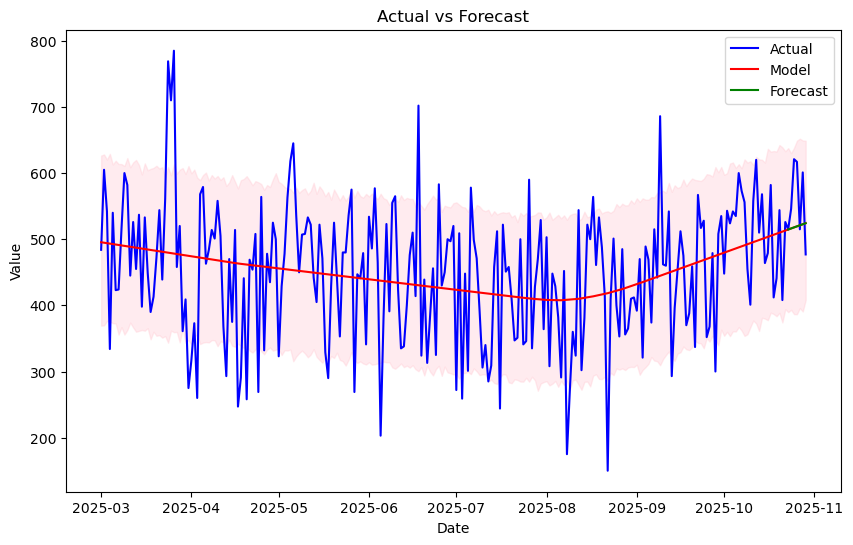

In [45]:
# Visualize time series plot
plt.figure(figsize=(10, 6))

plt.plot(prophet_df['ds'], prophet_df['y'], label='Actual', color='blue')
plt.plot(prophet_forecast['ds'], prophet_forecast['yhat'], label='Model', color='red')
plt.plot(prophet_forecast['ds'].tail(7), prophet_forecast['yhat'].tail(7), label='Forecast', color='green')

# Fill the uncertainty interval (between yhat_lower and yhat_upper) with a color similar to the model's 
plt.fill_between(prophet_forecast['ds'], prophet_forecast['yhat_lower'], prophet_forecast['yhat_upper'], color='pink', alpha=0.3)

plt.title('Actual vs Forecast')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

In [46]:
prophet_pred = prophet_forecast[['ds', 'yhat']].iloc[-periods:]
prophet_pred.set_index('ds', inplace=True)
prophet_pred

yhat
ds                    
2025-10-23  514.692191
2025-10-24  516.282939
2025-10-25  517.873687
2025-10-26  519.464435
2025-10-27  521.055183
2025-10-28  522.645931
2025-10-29  524.236679

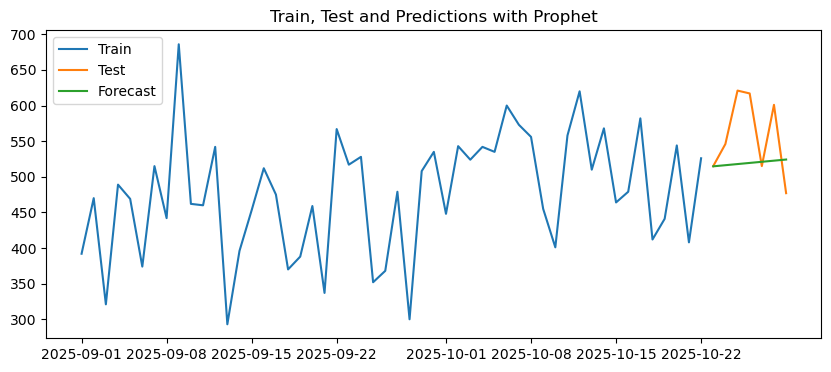

The RMSE is 64.85
The MAE is 51.76
The MAPE is 8.86 %


RMSE        MAE      MAPE
Prophet  64.850102  51.761811  0.088618

In [47]:
prophet_rmse, prophet_mae, prophet_mape = model_assessment(prophet_train.set_index('ds').loc['2025-09':], prophet_test.set_index('ds'), prophet_pred, 'Prophet')
prophet_metrics = pd.DataFrame(data={'RMSE': prophet_rmse, 'MAE': prophet_mae, 'MAPE': prophet_mape}, index=['Prophet'])
prophet_metrics

In [48]:
fig = plot_plotly(prophet_model, prophet_forecast)
py.iplot(fig)

The Prophet model fits a smooth curve with a quadratic-like trend and no visible structure or seasonality. Prophet seem to interpret the model as a gentle long-term drift with a quite stationary noise.<br> 
The model may perform even better if the seasonality or external regressors were applied.

# IN PROGRESS Neural networks

# IN PROGRESS Modeling forecast error using neural networks

# IN PROGRESS Modeling forecast error using GARCH

In [49]:
acorr_ljungbox(model_arima.resid**2, lags=10)

lb_stat  lb_pvalue
1   0.951551   0.329325
2   0.958032   0.619393
3   1.676906   0.642080
4   1.823630   0.768156
5   2.058603   0.840978
6   2.212005   0.899204
7   2.334341   0.939047
8   2.406471   0.965950
9   2.406760   0.983287
10  2.408600   0.992142

In [50]:
het_arch(model_arima.resid)

(7.4091847615317254,
 0.6863325680489185,
 0.7287473272797352,
 0.6969438025319841)

# Results summary

In [51]:
metrics = pd.concat([es_metrics, arima_metrics, prophet_metrics])
metrics

RMSE        MAE      MAPE
Simple ES  84.513007  69.583568  0.118118
Double ES  84.092237  69.220737  0.117509
Triple ES  82.805169  68.033841  0.115459
ARIMA      81.450479  68.670596  0.117292
Prophet    64.850102  51.761811  0.088618

In [52]:
print(
    f'Method with the lowest RMSE: {metrics['RMSE'].idxmin()}', 
    f'Method with the lowest MAE: {metrics['MAE'].idxmin()}', 
    f'Method with the lowest MAPE: {metrics['MAPE'].idxmin()}', 
    sep='\n'
     )

Method with the lowest RMSE: Prophet
Method with the lowest MAE: Prophet
Method with the lowest MAPE: Prophet


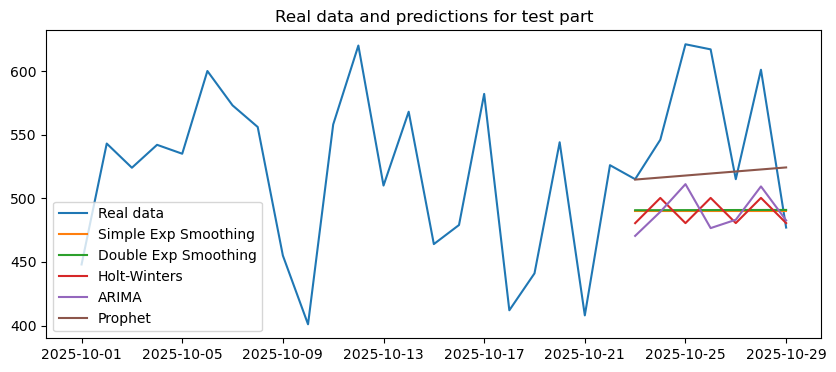

In [53]:
plt.figure(figsize = (10, 4))

plt.plot(df.loc['2025-10':], label = 'Real data')
#plt.plot(test.loc['2025-10':], label = 'Train')
plt.plot(ses_pred, label = 'Simple Exp Smoothing')
plt.plot(double_pred, label = "Double Exp Smoothing")
plt.plot(holt_pred, label = "Holt-Winters")
plt.plot(arima_pred, label = "ARIMA")
plt.plot(prophet_pred, label='Prophet')

plt.title(f"Real data and predictions for test part")
plt.legend()
plt.show()

The real data fluctuates heavily - large up-and-down movements and no consistent trend. Such irregularity makes it difficult for classical models (especially without seasonality or exogenous regressors) to capture the true dynamics. Most models therefore produce flat or slowly trending lines, which represent their “best guess” for a series with weak structure.<br>
Models’ performance suggests there is no systematic pattern to exploit - the irregular fluctuations are likely random or driven by external, unmodeled factors (e.g., varying dog activity, temperature, food measurement error, food type).<br>
Prophet model performs the best according to the selected error metrics. Exponential Smoothing methods and ARIMA achieved very similar metrics while Prophet's were clearly lower.

# Ideas of extending the analysis

<ul>
    <li>Including seasonality</li>
    <li>Adding regressors</li>
    <li>Selecting other methods</li>
    <li>Making hybrid models</li>
</ul>